# Evacuation Planning Simulation for Suzu City

This notebook implements an evacuation planning simulation for Suzu city (珠洲市) in Ishikawa Prefecture, Japan.

## City Information:
- Population: 13,531 (as of March 2021)
- Households: 6,013
- Population density: 54.6 persons per km²
- Total area: 247.20 km²

## Algorithms Used:
1. **Maximum Flow Problem**: To determine optimal evacuation routes and capacities
2. **Time-Expanded Network**: To model evacuation over time with dynamic constraints
3. **Combinatorial Optimization**: To find the best evacuation plan

## Simulation Components:
- Road network from OpenStreetMap
- Population distribution
- Evacuation shelters/safe zones
- Time-dependent evacuation flow


Libraries imported successfully!
Available CPU cores: 20
Available memory: 10.0 GB
Execution time for load_graph: 3.09s | Memory change: -415.2MB
Execution time for load_graph: 3.09s | Memory change: -415.2MB


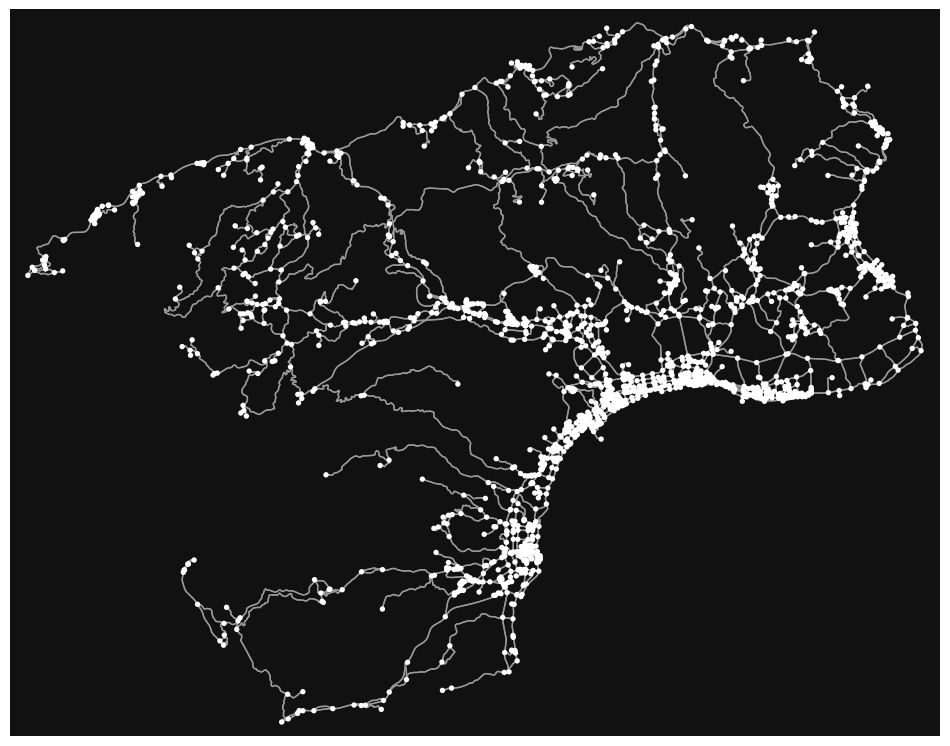

In [53]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

# Performance monitoring
import time
import psutil
import memory_profiler
from functools import wraps

# Animation and visualization imports
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from IPython.display import HTML, display, clear_output
import matplotlib.patches as patches
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

# Parallel processing optimization
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor, as_completed
from joblib import Parallel, delayed

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Performance monitoring decorator
def monitor_performance(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        result = func(*args, **kwargs)
        
        end_time = time.time()
        end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB
        
        print(f"Execution time for {func.__name__}: {end_time - start_time:.2f}s | Memory change: {end_memory - start_memory:+.1f}MB")
        return result
    return wrapper

print("Libraries imported successfully!")
print(f"Available CPU cores: {mp.cpu_count()}")
print(f"Available memory: {psutil.virtual_memory().available / 1024**3:.1f} GB")

place_name = "Suzu, Ishikawa, Japan"

@monitor_performance
def load_graph():
    return ox.graph_from_place(place_name, network_type='drive')

graph = load_graph()
fig, ax = ox.plot_graph(graph, figsize=(12, 10))



In [54]:
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)

In [55]:
edges.columns

Index(['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge',
       'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width',
       'est_width', 'access'],
      dtype='object')

In [56]:
# Get nodes and edges as GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph)

print(f"Network Statistics:")
print(f"Number of nodes: {len(nodes)}")
print(f"Number of edges: {len(edges)}")
print(f"\nNodes columns: {list(nodes.columns)}")
print(f"\nEdges columns: {list(edges.columns)}")

# Check the bounds of the network
bounds = nodes.total_bounds
print(f"\nNetwork bounds (lon_min, lat_min, lon_max, lat_max): {bounds}")
print(edges['length'])


Network Statistics:
Number of nodes: 1861
Number of edges: 5043

Nodes columns: ['y', 'x', 'street_count', 'junction', 'highway', 'geometry']

Edges columns: ['osmid', 'highway', 'oneway', 'reversed', 'length', 'bridge', 'geometry', 'name', 'ref', 'lanes', 'maxspeed', 'tunnel', 'width', 'est_width', 'access']

Network bounds (lon_min, lat_min, lon_max, lat_max): [137.0884597  37.3614715 137.3601281  37.5294151]
u            v            key
1281068967   1281085627   0      475.433891
             1281088757   0      308.617274
             1281093936   0      527.876788
1281068968   1281110312   0       63.387881
             1281147637   0      145.787930
                                    ...    
11554332531  11554332523  0       77.406863
             11491062922  0       24.558301
12193918084  1281126546   0       32.597996
             9572654173   0      181.919245
             1281092623   0       65.842164
Name: length, Length: 5043, dtype: float64


In [57]:
# Evacuation simulation parameters
class EvacuationParameters:
    def __init__(self):
        self.total_population = 13531  
        self.total_households = 6013
        self.city_area_km2 = 247.20
        self.population_density = 54.6
        
        # Evacuation parameters
        self.evacuation_time_limit = 1000
        self.time_step = 5  # minutes
        self.walking_speed = 5  # km/h
        self.driving_speed = 30  # km/h
        self.evacuation_modes = ['walking', 'driving']
        
        # Capacity parameters
        self.road_capacity_per_meter = 2  # persons per meter of road width
        self.default_road_width = 5
        
params = EvacuationParameters()
print(f"Evacuation Parameters:")
print(f"Total Population: {params.total_population:,}")
print(f"Evacuation Time Limit: {params.evacuation_time_limit} minutes")
print(f"Time Steps: {params.time_step} minutes")


Evacuation Parameters:
Total Population: 13,531
Evacuation Time Limit: 1000 minutes
Time Steps: 5 minutes


In [58]:
# Create population distribution across nodes
def distribute_population(nodes, total_population, method):
    """Distribute population across network nodes"""
    if method == 'random':
        # Randomly distribute population with some nodes having higher density
        weights = np.random.exponential(1, len(nodes))
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
        
    elif method == 'central':
        # Higher population in central areas
        center_lon = nodes.geometry.x.mean()
        center_lat = nodes.geometry.y.mean()
        
        distances = np.sqrt((nodes.geometry.x - center_lon)**2 + 
                           (nodes.geometry.y - center_lat)**2)
        weights = 1 / (1 + distances / distances.max())
        weights = weights / weights.sum()
        population = (weights * total_population).astype(int)
    
    return population

# Distribute population
nodes['population'] = distribute_population(nodes, params.total_population, method='random')

# Ensure total population matches
total_assigned = nodes['population'].sum()
if total_assigned != params.total_population:
    diff = params.total_population - total_assigned
    # Add difference to the node with highest population
    max_pop_idx = nodes['population'].idxmax()
    nodes.loc[max_pop_idx, 'population'] += diff

print(f"Population Distribution:")
print(f"Total population assigned: {nodes['population'].sum():,}")
print(f"Max population at single node: {nodes['population'].max():,}")
print(f"Average population per node: {nodes['population'].mean():.1f}")
print(f"Nodes with population > 0: {(nodes['population'] > 0).sum()}")

Population Distribution:
Total population assigned: 13,531
Max population at single node: 979
Average population per node: 7.3
Nodes with population > 0: 1596


In [59]:
# Define real shelter locations (NAME, LONGITUDE, LATITUDE)
shelter_data = [
    ("Misaki Elementary School", 137.3386079 ,37.4865063),
    ("Misaki Junior High School", 137.3421125, 37.4735508),
    ("Misaki Kominkan", 137.3417233 ,37.4741329, ),
    ("Misaki Day service Center", 137.3411659,37.4682916 ),
    ("Former Kodomari Elementary School", 137.3579202 ,37.4512824),
    ("Bishouen", 137.3546414, 37.4550024),
    ("Former Hon Elementary School", 137.3191886, 37.4669704),
    ("Wakayama Elementary School", 137.2380186, 37.4564239),
    ("Wakayama Kominkan", 137.2414873, 37.4567271),
    ("Former Kamikuromaru Elementary School", 137.1675344, 37.4531086),
    ("Naminohana Day Service Center Satellite",  137.1717194, 37.4529168),
    ("Uedo Kominkan", 137.2514576, 37.4275655 ),
    ("Uedo Elementary School",  137.2500348, 37.42733367),
    ("Shoin Kominkan", 137.294170, 37.4441519 ),
    ("Shoin Elementary School", 137.2963972, 37.4455364 ),
    ("Former Iizuka Nursery school",  137.287401, 37.46005),
    ("Hioki Kominkan", 137.2816343, 37.5256146),
    ("Naminohana Day Service Center", 137.1737721, 37.5002642 ),
    ("Otani Sho Junior High School", 137.176221, 37.499813 ),
    ("Otani Kominkan", 137.17389061 ,37.5017345),
    ("Takojima Kominkan", 137.3162568, 37.4429716),
    ("Takojima Elementary School", 137.3135001 ,37.4428631),
    ("Iida Kominkan", 137.2634559, 37.4386061 ),
    ("Iida Elementary School", 137.2595845, 37.44139991),
    ("Horyu Kominkan", 137.239350, 37.4015919),
    ("Horyu Elementary and Junior High School",  137.2377243, 37.4029323),
    ("Daisan Chojuen", 137.239173 ,37.4050800),
    ("Former Horyu Elementary School", 137.236946, 37.3967473),
    ("Chojuen", 137.240152, 37.4113336),
    ("Midorigaoka Junior High School", 137.2822918, 37.4426085),
    ("Tada Elementary School", 137.2816905, 37.4439484),
    ("Tada Kominkan", 137.280125, 37.44379726),
    ("Daini Chojuen", 137.2534331, 37.3449641),
    ("Matsunami Elementary School", 137.2447520, 37.3497276),
    ("Matsunami Junior High School",  137.244516, 37.346722),
    ("Uchiura Gymnasium",  137.2518157, 37.3428780),
    ("Shiromaru Community Facility",  137.2636797, 37.32681930),
    ("Noto Worker Plaza",  137.2345965, 37.3128900),
    ("Ogi Junior High School",  137.2232442, 37.3042909),
    ("Ogi Area Exchange Center",  137.2239980, 37.3006649),
    ("Ogi Elementary School",  137.223728, 37.2992604),
    ("Hime Exchange Center",  137.2125856, 37.29643723),
    ("Takakura Kominkan",  137.20855914, 37.3022237),
    ("Former Mawaki Elementary School",  137.2050652, 37.306543),
    ("Elderly Rest House Tanagisou",  137.1609513, 37.3032503),
    ("Shirasagi Nursery school", 137.1528388, 37.3091604 ),
    ("Children Mirai Center",  137.1487435, 37.30880138),
    ("Ushitsu Elementary School", 137.1461702, 37.3066262),
    ("Noto Gymnasium", 137.1484292, 37.3032023 ),
    ("Hibari Nursery school (Provisional Building)",137.1483707, 37.3024730 ),
    ("Sakiyama Sanson Kaihatsu Center", 137.1486993, 37.3028518),
    ("Noto Junior High School",137.1440288, 37.3025005),
    ("Yanai Tennis Court", 137.13351926, 37.2949099),
    ("Sannami Kominkan", 137.1170012, 37.2891499),
    ("Noto Shichimi Health Welfare no Go Nagomi", 137.0935441, 37.2664550),
    ("Ukawa Elementary School",  137.0830517, 37.2572431),
    ("Ukawa Nursery school",  137.0838109, 37.25452872),
    ("Ukawa Kominkan", 137.0851153, 37.25335004 ),
    ("Omo Kominkan",  137.1139702, 37.3796981),
    ("Yanagida Elementary School", 137.0962415, 37.3665538),
    ("Yanagida Nursery school", 137.0873315, 37.3734405),
    ("Concert Noto", 137.1482760, 37.3101367),
    ("Jinno Kominkan", 137.0839002, 37.3159556),
    ("Mizuho Kominkan", 137.040578,37.2804149),
    ("Yanagida Junior High School", 137.0928745, 37.36575890),
    ("Yanagida Gymnasium", 137.0924464, 37.3687055),
    ("Yanagida Kominkan",137.0958325, 37.36939063),
    ("Kanmachi Kominkan", 137.1088014, 37.3505403),
    ("Iwaido Kominkan", 137.0396952, 37.3648832),
    ("Akiyoshi Kominkan", 137.2387345, 37.3330286),
    ("Ishikawa Prefectural Noto Industry Gijutsu Semmonko", 137.2065864, 37.33772706),
    ("Ishikawa Prefectural Noto High School", 137.1505371, 37.2991115),
    ("Kanmachi Kominkan Goroku Branch Office", 137.1362070, 37.3396300),
    ("Fudoji Kominkan", 137.2097332, 37.3378086),
    ("Matsunami Kominkan", 137.2449241, 37.3535669)
]


# Identify evacuation shelters/safe zones based on predefined coordinates
def identify_evacuation_shelters_from_coords(nodes, predefined_shelters):
    """Identify evacuation shelters by finding the nearest available network node to predefined coordinates."""
    shelter_node_ids = []
    assigned_nodes = set()  # Track already assigned nodes
    
    if not predefined_shelters:
        print("No predefined shelters provided.")
        return []

    print(f"Processing {len(predefined_shelters)} shelters...")
    
    for i, (name, lon, lat) in enumerate(predefined_shelters):
        # Calculate distances to all nodes
        distances = np.sqrt((nodes.geometry.x - lon)**2 + (nodes.geometry.y - lat)**2)
        
        # Sort nodes by distance to find the nearest available one
        sorted_nodes = distances.sort_values()
        
        assigned_node = None
        for node_id in sorted_nodes.index:
            if node_id not in assigned_nodes:
                # Found an unassigned node
                assigned_node = node_id
                break
        
        if assigned_node is not None:
            shelter_node_ids.append(assigned_node)
            assigned_nodes.add(assigned_node)
            # Store shelter name on the node
            nodes.loc[assigned_node, 'shelter_name'] = name
            
            # Calculate distance for reporting
            distance = distances.loc[assigned_node]
            print(f"  {i+1:2d}. '{name}' -> Node {assigned_node} (distance: {distance:.6f})")
        else:
            print(f"  WARNING: Could not find available node for '{name}'")
    
    print(f"Successfully assigned {len(shelter_node_ids)} shelters to unique nodes")
    return shelter_node_ids

# Identify shelters using the predefined list
# You will need to populate `shelter_data` with actual (name, lon, lat) tuples
shelter_nodes = identify_evacuation_shelters_from_coords(nodes, shelter_data)

nodes['is_shelter'] = False
if shelter_nodes:
    nodes.loc[shelter_nodes, 'is_shelter'] = True

print(f"Evacuation Shelters:")
print(f"Number of shelters: {len(shelter_nodes)}")
# If you stored names and want to print them:
# for node_id in shelter_nodes:
# print(f"  Node ID: {node_id}, Name: {nodes.loc[node_id].get('shelter_name', 'N/A')}")
print(f"Shelter node IDs: {shelter_nodes}")


# Add capacity to shelters
nodes['shelter_capacity'] = 0 
if shelter_nodes: # Only assign capacities if shelters were identified
    shelter_capacities = np.random.randint(500, 1000, size=len(shelter_nodes))
    nodes.loc[shelter_nodes, 'shelter_capacity'] = shelter_capacities
    print(f"Total shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].sum():,}")
    print(f"Average shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].mean():.1f}")
    print(f"Min shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].min()}")
    print(f"Max shelter capacity: {nodes.loc[shelter_nodes, 'shelter_capacity'].max()}")
else:
    print("No shelters identified, so no capacities assigned.")

print(f"\\nDetailed shelter information:")
if shelter_nodes:
    shelter_info = nodes.loc[shelter_nodes, ['population', 'is_shelter', 'shelter_capacity', 'shelter_name']].copy()
    shelter_info.index.name = 'Node ID'
    print(shelter_info.sort_values('shelter_capacity', ascending=False))
else:
    print("No shelter information to display.")

Processing 75 shelters...
   1. 'Misaki Elementary School' -> Node 3762984021 (distance: 0.001070)
   2. 'Misaki Junior High School' -> Node 11506868426 (distance: 0.001034)
   3. 'Misaki Kominkan' -> Node 1281075355 (distance: 0.000684)
   4. 'Misaki Day service Center' -> Node 1281148941 (distance: 0.000908)
   5. 'Former Kodomari Elementary School' -> Node 1281148891 (distance: 0.000632)
   6. 'Bishouen' -> Node 1281106683 (distance: 0.001176)
   7. 'Former Hon Elementary School' -> Node 11493782008 (distance: 0.001218)
   8. 'Wakayama Elementary School' -> Node 11486765638 (distance: 0.001257)
   9. 'Wakayama Kominkan' -> Node 1281091320 (distance: 0.000389)
  10. 'Former Kamikuromaru Elementary School' -> Node 11476114070 (distance: 0.000279)
  11. 'Naminohana Day Service Center Satellite' -> Node 1281088408 (distance: 0.003097)
  12. 'Uedo Kominkan' -> Node 1281091172 (distance: 0.000735)
  13. 'Uedo Elementary School' -> Node 1281076637 (distance: 0.000436)
  14. 'Shoin Kominkan

In [60]:
# Calculate edge capacities and travel times
def calculate_edge_properties(edges, params):
    """Calculate capacity and travel time for each edge"""
    # Convert to numeric values, handling string values
    width_series = pd.to_numeric(edges['width'], errors='coerce')
    est_width_series = pd.to_numeric(edges['est_width'], errors='coerce')
    edges['width_calc'] = width_series.fillna(est_width_series).fillna(params.default_road_width)
    
    # Calculate capacity based on road width and length
    edges['capacity'] = (edges['width_calc'] * edges['length'] * params.road_capacity_per_meter / 100).astype(int)
    edges['capacity'] = edges['capacity'].clip(lower=10)  # Ensure minimum capacity of 10   
    
    # Calculate travel times (in minutes)
    # Walking time
    edges['walk_time'] = (edges['length'] / 1000) / params.walking_speed * 60  # minutes
    
    # Driving time (use maxspeed if available)
    max_speeds = edges['maxspeed'].fillna(params.driving_speed)
    # Convert string speeds to numeric
    max_speeds = pd.to_numeric(max_speeds, errors='coerce').fillna(params.driving_speed)
    edges['drive_time'] = (edges['length'] / 1000) / max_speeds * 60  # minutes
    
    return edges

# Calculate edge properties
edges = calculate_edge_properties(edges, params)

print(f"Edge Properties:")
print(f"Capacity - Min: {edges['capacity'].min()}, Max: {edges['capacity'].max()}, Mean: {edges['capacity'].mean():.1f}")
print(f"Walk time - Min: {edges['walk_time'].min():.2f}, Max: {edges['walk_time'].max():.2f} minutes")
print(f"Drive time - Min: {edges['drive_time'].min():.2f}, Max: {edges['drive_time'].max():.2f} minutes")

Edge Properties:
Capacity - Min: 10, Max: 560, Mean: 25.6
Walk time - Min: 0.01, Max: 67.27 minutes
Drive time - Min: 0.00, Max: 11.21 minutes


In [61]:
# Add west exit point to the evacuation network
def add_west_exit(nodes, edges, graph):
    """Add a west exit point for evacuation"""
    # Find the westernmost area of the city
    west_lon = nodes.geometry.x.min()
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    west_threshold = west_lon + (lon_range * 0.15)
    
    # Get nodes in the western area
    west_nodes = nodes[nodes.geometry.x <= west_threshold]
    
    # Select the westernmost node as the exit point
    west_exit_node = west_nodes.geometry.x.idxmin()
    
    # Mark this node as a west exit
    nodes.loc[west_exit_node, 'is_west_exit'] = True
    nodes.loc[west_exit_node, 'exit_capacity'] = 10000
    
    print(f"West exit created at node {west_exit_node}")
    print(f"Exit location: ({nodes.loc[west_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_exit_node, 'geometry'].y:.4f})")
    
    return west_exit_node

# Initialize exit columns if they don't exist
if 'is_west_exit' not in nodes.columns:
    nodes['is_west_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

def add_south_exit(nodes, edges, graph):
    """Add a south exit point for evacuation, using latitude between 37.4 and 37.45 and longitude between 137.15 and 137.2"""

    south_nodes = nodes[(nodes.geometry.y >= 37.4) & (nodes.geometry.y <= 37.45) & (nodes.geometry.x >= 137.15) & (nodes.geometry.x <= 137.2)]
    
    if south_nodes.empty:
        raise ValueError("No nodes found in the latitude range 37.4 to 37.45")
    
    # Select the southernmost node within this range
    south_exit_node = south_nodes.geometry.y.idxmin()
    
    # Mark this node as a south exit
    nodes.loc[south_exit_node, 'is_south_exit'] = True
    nodes.loc[south_exit_node, 'exit_capacity'] = 10000
    
    print(f"South exit created at node {south_exit_node}")
    print(f"Exit location: ({nodes.loc[south_exit_node, 'geometry'].x:.4f}, {nodes.loc[south_exit_node, 'geometry'].y:.4f})")
    
    return south_exit_node

def add_west_south_exit(nodes, edges, graph):
    """Add a west-south exit point for evacuation in the southwestern area"""
    #
    west_lon = nodes.geometry.x.min()
    south_lat = nodes.geometry.y.min()
    
    lon_range = nodes.geometry.x.max() - nodes.geometry.x.min()
    lat_range = nodes.geometry.y.max() - nodes.geometry.y.min()
    
    west_threshold = west_lon + (lon_range * 0.15) 
    south_threshold = south_lat + (lat_range * 0.15) + 0.07
    print(f"West-South exit thresholds: West {west_threshold:.4f}, South {south_threshold:.4f}")
    
    # Get nodes in the southwestern area
    southwest_nodes = nodes[
        (nodes.geometry.x >= west_threshold) & 
        (nodes.geometry.y >= south_threshold)
    ]
    
    if len(southwest_nodes) == 0:
        # If no nodes in the strict southwestern area, expand the search
        west_threshold = west_lon + (lon_range * 0.15) 
        south_threshold = south_lat + (lat_range * 0.15) + 0.07
        southwest_nodes = nodes[
            (nodes.geometry.x >= west_threshold) & 
            (nodes.geometry.y >= south_threshold)
        ]
    print(f"Southwest nodes found: {len(southwest_nodes)}")
    # Select the node that is closest to the southwest corner
    if len(southwest_nodes) > 0:
        # Calculate distance to southwest corner
        distances = np.sqrt(
            (southwest_nodes.geometry.x - west_lon)**2 + (southwest_nodes.geometry.y - south_lat)**2
        )
        west_south_exit_node = distances.idxmin()
    else:
        # Fallback: select the westernmost node among the southernmost nodes
        south_nodes = nodes[nodes.geometry.y <= south_lat + (lat_range * 2)] 
        west_south_exit_node = south_nodes.geometry.x.idxmin()
    
    # Mark this node as a west-south exit
    nodes.loc[west_south_exit_node, 'is_west_south_exit'] = True
    nodes.loc[west_south_exit_node, 'exit_capacity'] = 10000 
    
    print(f"West-South exit created at node {west_south_exit_node}")
    print(f"Exit location: ({nodes.loc[west_south_exit_node, 'geometry'].x:.4f}, {nodes.loc[west_south_exit_node, 'geometry'].y:.4f})")
    
    return west_south_exit_node

# Initialize exit columns if they don't exist
if 'is_south_exit' not in nodes.columns:
    nodes['is_south_exit'] = False
if 'is_west_south_exit' not in nodes.columns:
    nodes['is_west_south_exit'] = False
if 'exit_capacity' not in nodes.columns:
    nodes['exit_capacity'] = 0

add_west_exit(nodes, edges, graph)
add_south_exit(nodes, edges, graph)
add_west_south_exit(nodes, edges, graph)


West exit created at node 1281123728
Exit location: (137.0885, 37.4693)
South exit created at node 1281108573
Exit location: (137.1791, 37.4212)
West-South exit thresholds: West 137.1292, South 37.4567
Southwest nodes found: 802
West-South exit created at node 1281090837
Exit location: (137.1333, 37.4636)


np.int64(1281090837)

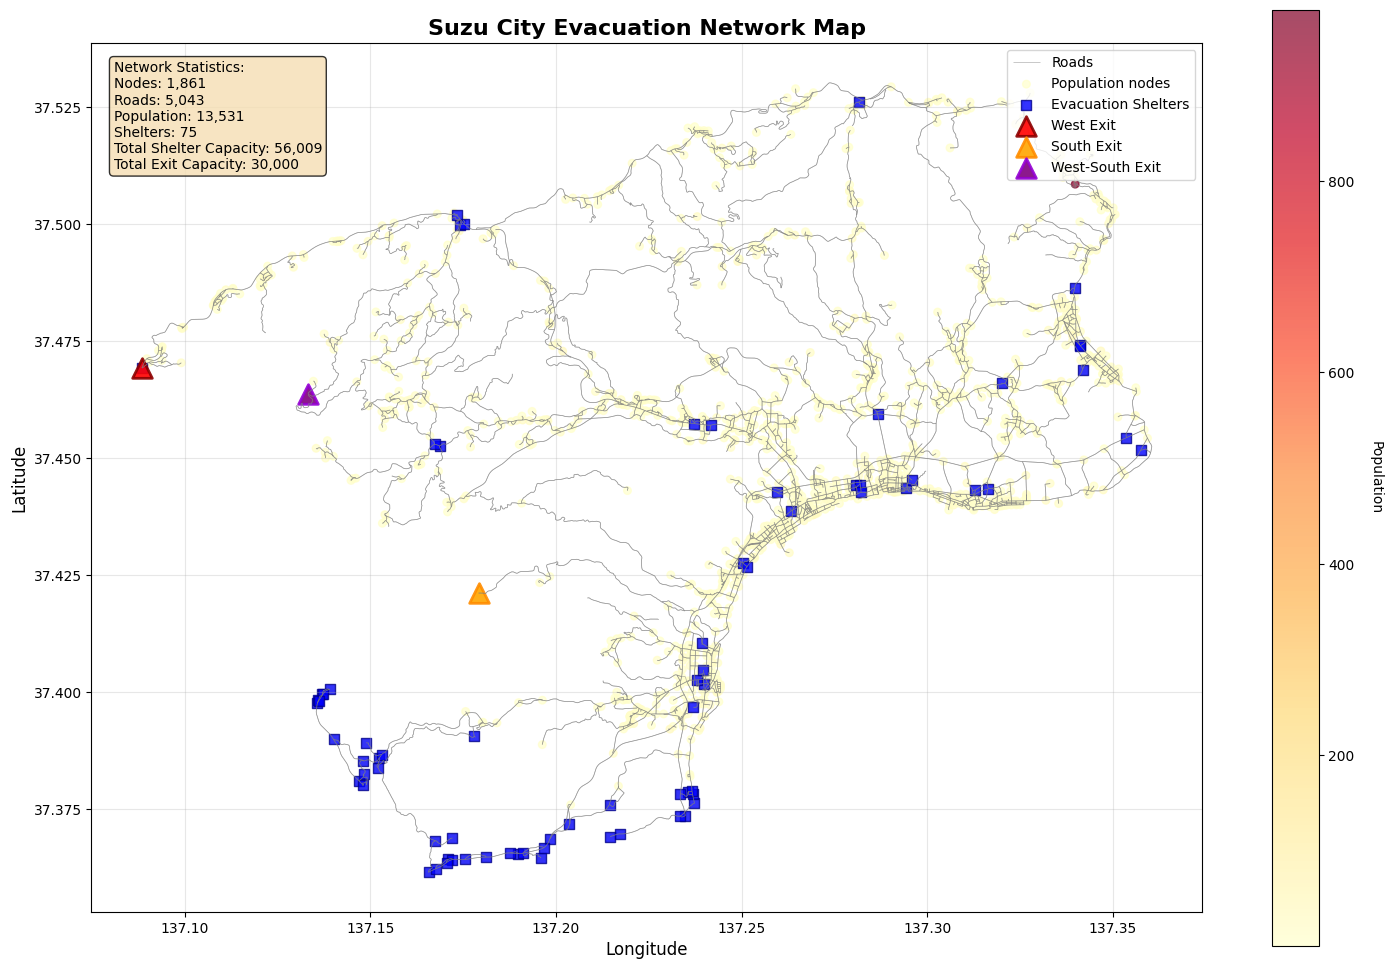


BASIC MAXIMUM FLOW ANALYSIS
Error in basic max flow: MultiGraph and MultiDiGraph not supported (yet).
Basic max flow analysis failed!


In [62]:
# Create a comprehensive map showing the evacuation network
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Plot the road network
edges.plot(ax=ax, linewidth=0.5, alpha=0.6, color='gray', label='Roads')

# Plot all nodes with population
nodes_with_pop = nodes[nodes['population'] > 0]
scatter = ax.scatter(nodes_with_pop.geometry.x, nodes_with_pop.geometry.y, 
                                        c=nodes_with_pop['population'], cmap='YlOrRd', 
                                        s=30, alpha=0.7, label='Population nodes')

# Plot evacuation shelters
shelter_nodes_data = nodes[nodes['is_shelter']]
ax.scatter(shelter_nodes_data.geometry.x, shelter_nodes_data.geometry.y, 
                  c='blue', s=50, marker='s', alpha=0.8, label='Evacuation Shelters', 
                  edgecolors='darkblue', linewidth=1)

# Plot west exit
west_exit_data = nodes[nodes['is_west_exit']]
ax.scatter(west_exit_data.geometry.x, west_exit_data.geometry.y, 
                  c='red', s=200, marker='^', alpha=0.9, label='West Exit', 
                  edgecolors='darkred', linewidth=2)

# Plot south exit
south_exit_data = nodes[nodes['is_south_exit']]
ax.scatter(south_exit_data.geometry.x, south_exit_data.geometry.y, 
                  c='orange', s=200, marker='^', alpha=0.9, label='South Exit', 
                  edgecolors='darkorange', linewidth=2)

# Plot west-south exit
west_south_exit_data = nodes[nodes['is_west_south_exit']]
ax.scatter(west_south_exit_data.geometry.x, west_south_exit_data.geometry.y, 
                  c='purple', s=200, marker='^', alpha=0.9, label='West-South Exit', 
                  edgecolors='darkviolet', linewidth=2)

# Add colorbar for population
cbar = plt.colorbar(scatter, ax=ax, shrink=0.8)
cbar.set_label('Population', rotation=270, labelpad=20)

# Add title and labels
ax.set_title('Suzu City Evacuation Network Map', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add legend
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Add grid
ax.grid(True, alpha=0.3)

# Calculate correct exit capacities
total_exit_capacity = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']]['exit_capacity'].sum()

# Add statistics text box
stats_text = f"""Network Statistics:
Nodes: {len(nodes):,}
Roads: {len(edges):,}
Population: {nodes['population'].sum():,}
Shelters: {len(shelter_nodes)}
Total Shelter Capacity: {nodes['shelter_capacity'].sum():,}
Total Exit Capacity: {total_exit_capacity:,}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# Basic Maximum Flow Analysis (without time expansion)
def basic_max_flow_analysis(graph, nodes, shelter_nodes):
    """Perform basic maximum flow analysis without time expansion"""
    print("\n" + "="*50)
    print("BASIC MAXIMUM FLOW ANALYSIS")
    print("="*50)
    
    # Create flow network
    flow_graph = graph.copy()
    
    # Add super source and sink
    flow_graph.add_node('super_source')
    flow_graph.add_node('super_sink')
    
    # Connect population sources
    total_population = 0
    for node_id in nodes.index:
        population = nodes.loc[node_id, 'population']
        if population > 0:
            flow_graph.add_edge('super_source', node_id, capacity=int(population))
            total_population += population
    
    # Connect shelters to sink
    for shelter in shelter_nodes:
        capacity = nodes.loc[shelter, 'shelter_capacity']
        flow_graph.add_edge(shelter, 'super_sink', capacity=int(capacity))
    
    # Connect exits to sink
    exit_nodes = nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']].index
    for exit_node in exit_nodes:
        capacity = nodes.loc[exit_node, 'exit_capacity']
        flow_graph.add_edge(exit_node, 'super_sink', capacity=int(capacity))
    
    # Calculate maximum flow
    try:
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'super_source', 'super_sink')
        
        print(f"Results:")
        print(f"Total population: {total_population:,}")
        print(f"Maximum evacuable: {flow_value:,}")
        print(f"Evacuation rate: {flow_value/total_population:.2%}")
        
        return {
            'flow_value': flow_value,
            'flow_dict': flow_dict,
            'total_population': total_population,
            'evacuation_rate': flow_value/total_population
        }
    except Exception as e:
        print(f"Error in basic max flow: {e}")
        return None

# Run basic analysis
basic_results = basic_max_flow_analysis(graph, nodes, shelter_nodes)

if basic_results:
    print(f"\nBasic max flow analysis completed successfully!")
else:
    print(f"Basic max flow analysis failed!")

In [63]:

G = nx.DiGraph()
G.add_nodes_from(nodes.index)
for idx, row in edges.iterrows():
    # idx is a tuple: (u, v, key)
    u, v = idx[0], idx[1]
    G.add_edge(u, v, 
               capacity=row['capacity'], 
               walk_time=row['walk_time'], 
               drive_time=row['drive_time'],
               length=row['length'])
    
# Add shelter and exit attributes to nodes
for node_id in nodes.index:
    G.nodes[node_id]['population'] = nodes.loc[node_id, 'population']
    G.nodes[node_id]['is_shelter'] = nodes.loc[node_id, 'is_shelter']
    G.nodes[node_id]['shelter_capacity'] = nodes.loc[node_id, 'shelter_capacity']
    G.nodes[node_id]['is_west_exit'] = nodes.loc[node_id, 'is_west_exit']
    G.nodes[node_id]['is_south_exit'] = nodes.loc[node_id, 'is_south_exit']
    G.nodes[node_id]['is_west_south_exit'] = nodes.loc[node_id, 'is_west_south_exit']
    G.nodes[node_id]['exit_capacity'] = nodes.loc[node_id, 'exit_capacity']


def calculate_max_flow(G, source, target):
    """Calculate maximum flow from source to target using the shortest augmenting path algorithm."""
    flow_value, flow_dict = nx.maximum_flow(G, source=source, target=target, flow_func=shortest_augmenting_path)
    return flow_value, flow_dict
def find_shelter_for_population(G, population):
    """Find the best shelter for a given population based on available capacity."""
    shelters = [n for n in G.nodes if G.nodes[n].get('is_shelter', False)]
    shelter_capacities = {s: G.nodes[s]['shelter_capacity'] for s in shelters}
    
    # Sort shelters by capacity
    sorted_shelters = sorted(shelter_capacities.items(), key=lambda x: x[1], reverse=True)
    
    total_capacity = 0
    selected_shelters = []
    
    for shelter, capacity in sorted_shelters:
        if total_capacity >= population:
            break
        selected_shelters.append(shelter)
        total_capacity += capacity
    
    return selected_shelters, total_capacity



In [64]:
from networkx.algorithms.flow import shortest_augmenting_path
from concurrent.futures import ProcessPoolExecutor, as_completed

# Calculate maximum flow from each node with population to all shelters and exits using parallel processing

# Collect all sink nodes (shelters and exits)
sink_nodes = set(shelter_nodes) | set(nodes[nodes['is_west_exit'] | nodes['is_south_exit'] | nodes['is_west_south_exit']].index)

# Only consider nodes with population > 0 and not a sink
source_nodes = [n for n in nodes_with_pop.index if n not in sink_nodes]

def max_flow_for_source(source):
    max_flow = 0
    for sink in sink_nodes:
        if source != sink:
            try:
                flow_value, _ = nx.maximum_flow(G, source, sink, flow_func=shortest_augmenting_path)
                max_flow = max(max_flow, flow_value)
            except nx.NetworkXError:
                continue
    return source, max_flow

max_flows = {}
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(max_flow_for_source, source): source for source in source_nodes}
    for future in as_completed(futures):
        source, max_flow = future.result()
        max_flows[source] = max_flow



In [65]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes with highest max flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

Top 10 nodes with highest max flow to any shelter/exit:
Node 1281080861: Max flow = 340
Node 1281071904: Max flow = 334
Node 1281074342: Max flow = 228
Node 1281134163: Max flow = 213
Node 1281069274: Max flow = 185
Node 1281070629: Max flow = 171
Node 1281143950: Max flow = 171
Node 1281137017: Max flow = 161
Node 11491968379: Max flow = 160
Node 1281083343: Max flow = 128


In [66]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=False)[:10]
print("Top 10 nodes with lowest min flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

Top 10 nodes with lowest min flow to any shelter/exit:
Node 1281069369: Max flow = 10
Node 1281070433: Max flow = 10
Node 1281071151: Max flow = 10
Node 1281072920: Max flow = 10
Node 1281074759: Max flow = 10
Node 1281075196: Max flow = 10
Node 1281075412: Max flow = 10
Node 1281076042: Max flow = 10
Node 1281076871: Max flow = 10
Node 1281079546: Max flow = 10


In [67]:
top_flows = sorted(max_flows.items(), key=lambda x: x[1], reverse=True)[:-1]
print("max flow to any shelter/exit:")
for node, flow in top_flows:
    print(f"Node {node}: Max flow = {flow}")

max flow to any shelter/exit:
Node 1281080861: Max flow = 340
Node 1281071904: Max flow = 334
Node 1281074342: Max flow = 228
Node 1281134163: Max flow = 213
Node 1281069274: Max flow = 185
Node 1281070629: Max flow = 171
Node 1281143950: Max flow = 171
Node 1281137017: Max flow = 161
Node 11491968379: Max flow = 160
Node 1281083343: Max flow = 128
Node 1281092912: Max flow = 128
Node 1281093788: Max flow = 128
Node 1281070188: Max flow = 126
Node 1281088443: Max flow = 126
Node 1281111248: Max flow = 126
Node 1281128350: Max flow = 126
Node 1281143491: Max flow = 126
Node 1281147953: Max flow = 126
Node 1281085854: Max flow = 122
Node 1281107349: Max flow = 122
Node 1281111405: Max flow = 122
Node 1281131571: Max flow = 122
Node 1281084763: Max flow = 119
Node 1281133795: Max flow = 119
Node 11486488394: Max flow = 119
Node 11489735500: Max flow = 119
Node 1281076491: Max flow = 117
Node 1281078071: Max flow = 117
Node 1281088539: Max flow = 117
Node 1281125352: Max flow = 117
Node 12